In [1]:
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
size = 256
batch_size = 128
epochs = 20
history = {}
def build_model(initializer, optimizer):
    input_shape = (size, size, 3)
    hidden_layer_1 = 1024
    hidden_layer_2 = 512
    num_classes = 39
    layers = [
        Flatten(input_shape=input_shape),
        BatchNormalization(),
        Dense(hidden_layer_1, kernel_initializer=initializer, activation='relu'),
        BatchNormalization(),
        Dense(hidden_layer_2, kernel_initializer=initializer, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax', kernel_initializer=initializer)
    ]
    model = tf.keras.Sequential(layers)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
    return model

In [3]:
optim = {}
sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
optim['sgd_momentum'] = sgd_momentum
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optim['adam'] = adam
initializer = tf.keras.initializers.HeNormal()

In [4]:
train_path = '../input/traindata/train_aug'
test_path = '../input/testdata/test'
train_gen = ImageDataGenerator(rescale=1./255, vertical_flip=True, brightness_range=(0.2, 0.8))
test_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(train_path,     
    target_size = (size, size),
    shuffle=True, 
    batch_size=batch_size
)
valid_generator = test_gen.flow_from_directory(test_path,     
    target_size = (size, size),
    shuffle=False, 
    batch_size=batch_size
)

Found 53164 images belonging to 39 classes.
Found 11104 images belonging to 39 classes.


In [5]:
def train_model(k, v):
    model = build_model(initializer, v)
    model.summary()
    print('This is a model using:', k)
    model_save = ModelCheckpoint('./ANN_BN_after_activation_' + k + '.h5',
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = 'val_loss', 
                                 mode = 'min', verbose = 1)
    milestone = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size - 1,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, early_stop, reduce_lr]
              )
    history[k] = milestone

In [6]:

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)

for k, v in optim.items():
    train_model(k, v)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 196608)            786432    
_________________________________________________________________
dense (Dense)                (None, 1024)              201327616 
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 39)                2

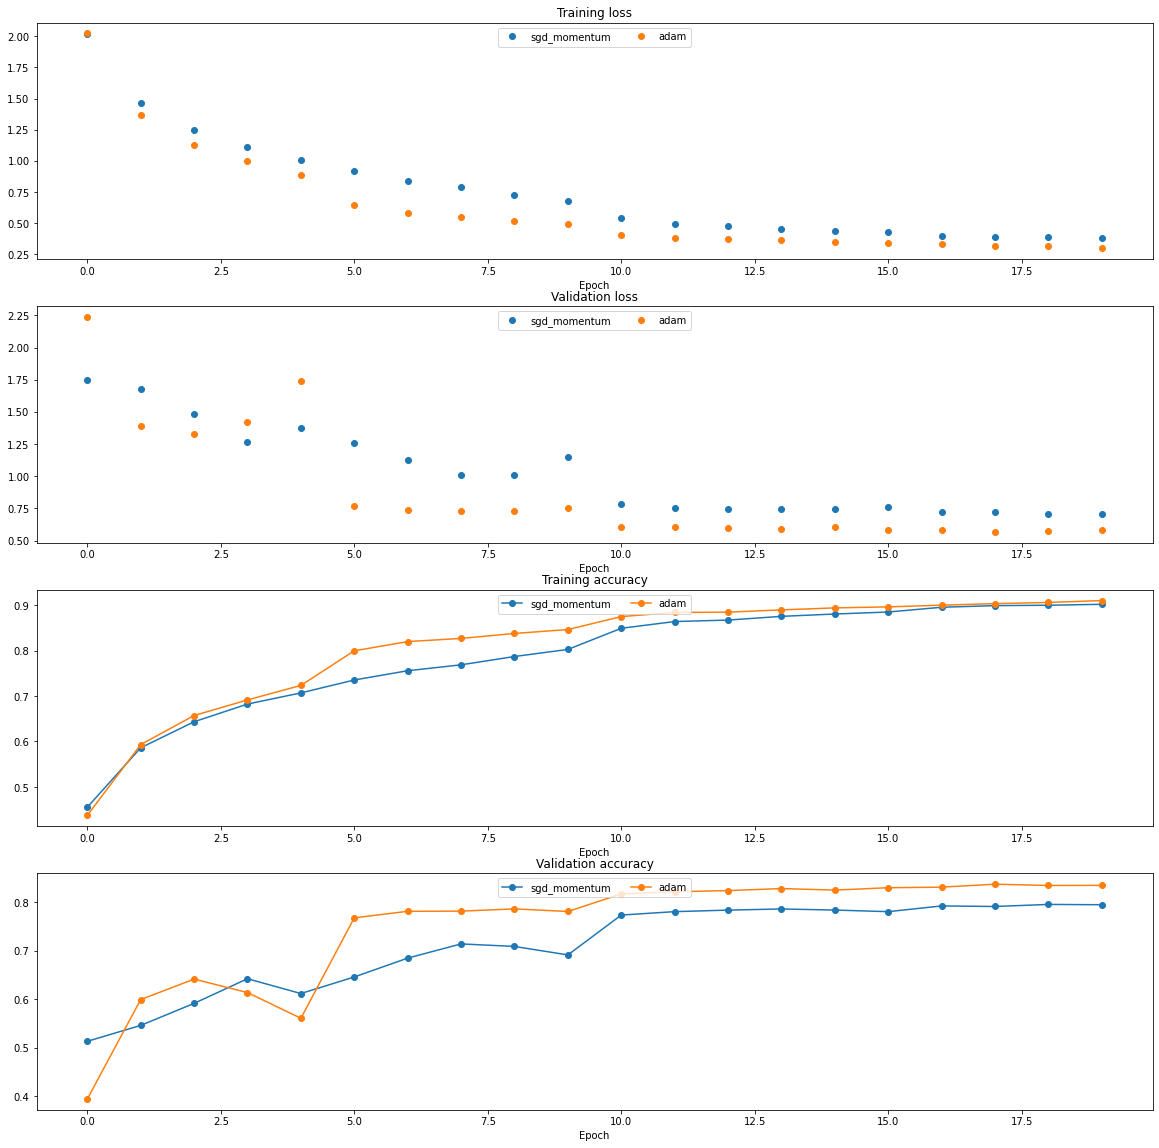

In [7]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)
    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()